#### Imports

In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS

from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

#### Data Preparation

In [2]:
data = pd.read_csv('data/Credit.csv', usecols=range(1,12))
data.head(9)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
5,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
6,20.996,3388,259,2,37,12,Female,No,No,African American,203
7,71.408,7114,512,2,87,9,Male,No,No,Asian,872
8,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279


EX1: If this would be the whole dataset we could not use OLS since p > n. Therefore, shirnkage methods would be required.

In [3]:
# Splitt data into regressors X and target y and create dummy variables for categorical variables
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = data.loc[:, data.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = data.loc[:, 'Balance']

#### Lasso Regression

Showing the relative magnitude of the Lasso coefficients

In [4]:
def fit_lasso(X, y, alpha):
    lasso = Lasso()

    # scale the data
    X_scaled = scale(X)

    # no need sklearn lasso can deal with non centered data
    y_mod = y - np.mean(y) # this will set intercept to ~0
    # y_mod = y

    lasso.set_params(alpha=alpha)
    # fit the model
    lasso.fit(X_scaled, y_mod)
    
    # intercept is mean if not modified before
    # print(lasso.intercept_)
    # print(np.mean(y))

    # show coefficients and their name from dataset
    return lasso.coef_

In [5]:
pd.Series(fit_lasso(X, y, 10**1), index=X.columns)

Income                -228.476604
Limit                  335.295534
Rating                 233.092151
Cards                   12.897087
Age                     -4.058972
Education               -0.000000
Gender_Female           -0.000000
Student_Yes            116.127917
Married_Yes             -0.000000
Ethnicity_Asian          0.000000
Ethnicity_Caucasian      0.000000
dtype: float64

Showing the effect of alpha on the coefficients

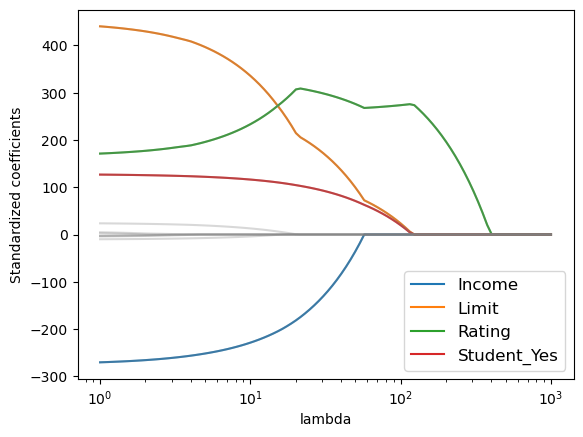

In [6]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(0, 3, n_grid)

lasso = Lasso()
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso_coefs.append(fit_lasso(X, y, a))
lasso_coefs = np.reshape(lasso_coefs, (n_grid, -1))

highlight = [i for i,j in enumerate(lasso_coefs[0]) if abs(j) > 50]
highlight_names = [name for i,name in enumerate(X.columns) if i in highlight]

# Plot coefficients - absolute
fig, ax1 = plt.subplots()
ax1.plot(alphas, lasso_coefs[:,highlight], alpha=1)
ax1.plot(alphas, lasso_coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized coefficients')
ax1.legend(highlight_names, fontsize=12)

EX2a: The most influencal regressors are "Income", "Limit", "Rating", and "Student"

#### 10-fold cross-validation

In [7]:
# Get MSE
def k_fold_lasso(X, y, a, n_splits=10):
    # Init mse
    X_scaled = scale(X)
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=n_splits, random_state=None, shuffle=False)
    kf10.get_n_splits(X_scaled)
    
    # Loop over splits
    for train_index, test_index in kf10.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=a).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [19]:
alphas = 10**np.linspace(0, 4, 40)
# add 0.01 to alphas
alphas = np.append(0.01, alphas)

MSE = [k_fold_lasso(X,y,a,10) for a in alphas]

Text(0, 0.5, 'MSE')

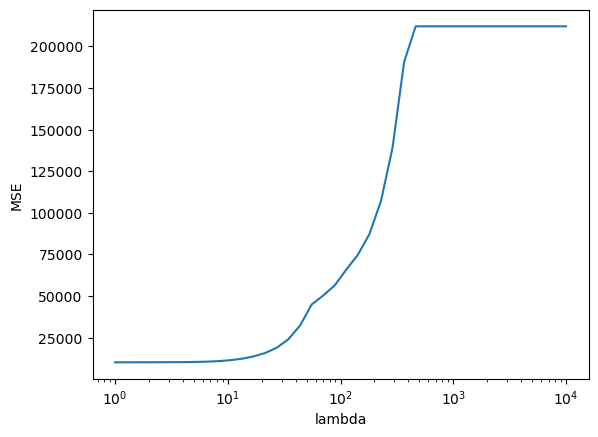

In [17]:
# plot MSE
fig, ax1 = plt.subplots()
ax1.plot(alphas, MSE)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('MSE')

In [20]:
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha is:', alpha_min)

Best alpha is: 0.01


EX2b: Based on 10-fold cross validation Lasso is not an desired method for this Problem if the target is prediction accuracy since the optimal $\lambda$ is most likely 0

#### Post-Lasso

In [11]:
def post_lasso(X, y, alpha):
    
    # scale regressors
    X_scaled = scale(X)
    # fit lasso
    coefficients = fit_lasso(X, y, alpha)
    # select regressors != 0
    selected_regressors = [X.columns[i] for i,j in enumerate(coefficients) if j != 0]
    # define subset
    X_subset = X.loc[:, selected_regressors]
    # transform boolean into int for categorical values. Only needed in OSL, Lasso does it by itself.
    categorical = X_subset.select_dtypes(bool)
    X_subset[categorical.columns] = categorical.astype(int)
    
    # OLS Regression
    reg = OLS(y, add_constant(X_subset), hasconst=True).fit()
    return reg.params

print(post_lasso(X, y, 10))

const         -493.734187
Income          -7.795082
Limit            0.193691
Rating           1.091187
Cards           18.211898
Age             -0.624056
Student_Yes    425.609937
dtype: float64
